# 1. Imports

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [2]:
import numpy as np

from __future__ import division

import lal
import lalsimulation

from pycbc.conversions import *
import pycbc.types 
import pycbc.noise
import pycbc.psd
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
from astropy import cosmology
import pycbc.filter
from pycbc.filter import sigmasq
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.filter import resample_to_delta_t, highpass, matched_filter
from pycbc.frame import read_frame
import pylab



from pycbc.catalog import Merger

from scipy.stats import norm
from scipy import interpolate
from numpy import pi
from numpy import arange
from scipy import constants
import matplotlib.pyplot as plt
import seaborn as sns

import math
import matplotlib.pyplot as plt
from statistics import mean, stdev

# 1. Matched filter

## Downsample to 2048Hz

Before working with the data in any form, we must import it and convert it into an useful format. 

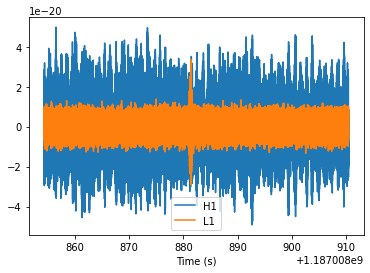

In [3]:
merger = Merger("GW170817")
strain, stilde = {}, {}
#Loops through the LIGO Hanford and the Livingston parts of the data
for ifo in ['H1', 'L1']:

    # importing the the data 128 seconds around the spike 
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                    start_time=merger.time - 32,
                   end_time=merger.time + 32,
                   check_integrity=False)

    # Remove the low frequency content and downsample the data to 2048Hz
    strain[ifo] = highpass(ts,15.0)
    # #remove the begining and ending spikes from the data
    strain[ifo] = strain[ifo].crop(4, 4)
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

    #plotting both datasets
    pylab.plot(strain[ifo].sample_times, strain[ifo], label=ifo)

pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

## Matched filter between the data and the template Waveform

In a first step we plot the Power Spectral Desity of the dataSet. This will allow us to whiten the data in a later step, which is crutial in order to find the Signal to Noise Ratio (SNR).

0.017857142857142856

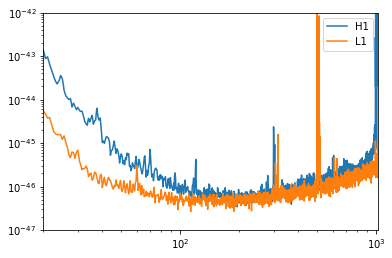

In [4]:
from pycbc.psd import interpolate

psds = {}
for ifo in ['H1', 'L1']:


    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)

pylab.legend()
psds[ifo].delta_f

## Best Mass

In order to find the best template waveform, we have to estimate which masses lead to the best Signal to Noise Ratio(SNR). The highest SNR indecates how well the template waveform matches the dataset. 

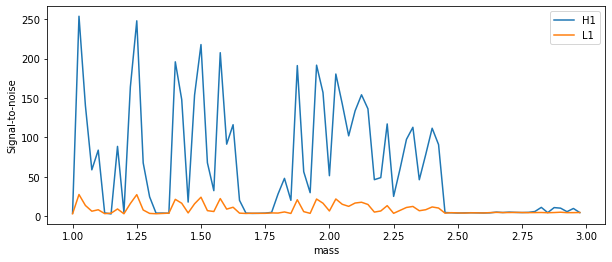

In [5]:
# Creating all additional variables needed
Snr_list = []
snrs = {}

masses = arange(1,3,0.025)

# Looping through both parts of the data
for ifo in ['H1', 'L1']:
  # Looping through the list of masses
  for m in masses:

    # Generating a waveform with binary masses m 
    hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=20.0)
    
    hp.resize(len(strain[ifo]))
    # Creating a template from the generated waveform 
    template = hp.cyclic_time_shift(hp.start_time)
    # Estimating the SNR between the template and the data
    snr = matched_filter(template, strain[ifo],
                          psd=psds[ifo], 
                          low_frequency_cutoff=15.0)
    snr1 = snr.crop(4 + 4, 4)
    # Saving the information into a plotable format 
    snrs[ifo] = Snr_list.append(max(abs(snr1)))
  snrs[ifo] = Snr_list
  Snr_list = []

pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label = 'H1')
pylab.plot(masses, snrs['L1'], label = 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

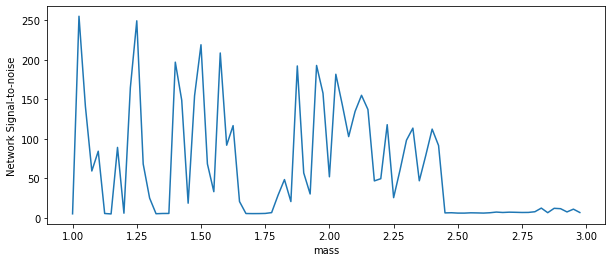

We found the best Mass1=Mass2 was 1.02 solar masses (detector frame)


In [6]:
# Now we will combine the SNR's from the H1 and L1 data 
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(masses, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()
bestMass = masses[ii]
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])

## Create the template

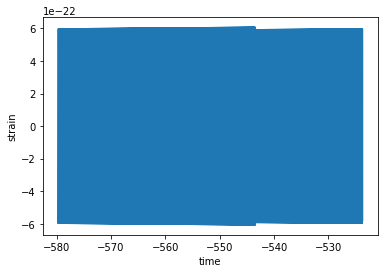

In [7]:

#  Using the masses, which we found in the previous part, we can create a 
#  template with all known parameters

m = 1.025 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=15.0)
# resize to match our data
hp.resize(len(strain[ifo]))

# The template must now be fitted onto the data. In order to do so, we first 
# must find the correct starting postition for the signal. 

# Using the cyclic_time_shift function we can rotate the vector around the data, 
# which us cast into a cyclic format. 

template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

Next we will try to fit the template onto the data 

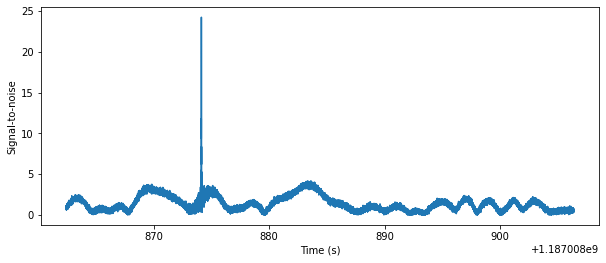

We found a signal at 1187008874.1158204s with SNR 24.242193711153917


In [8]:

ifo = 'L1'                            
conditioned = strain[ifo]

snr = matched_filter(template, conditioned,
                     psd=psds[ifo], low_frequency_cutoff=15)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.

snr = snr.crop(4 + 4, 4)


# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.



pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

We find a very clear signal with a SNR of over 24. 

## Q-Transform

In [9]:
from pycbc.filter import sigma

# The peak of the SNR curve provides all information needed to align the 
# template with the data

# Alligns the data with the time 
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=15)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

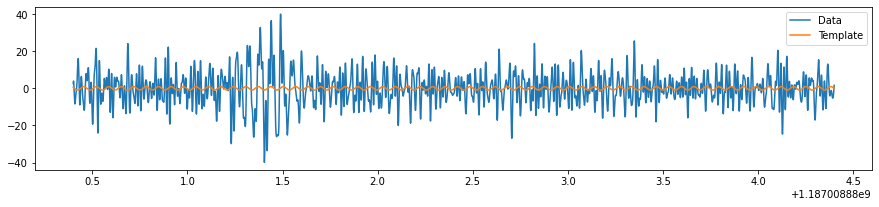

In [10]:

# whiten the data 
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(15, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()


white_data = white_data.highpass_fir(15., 512).lowpass_fir(80, 512)
white_template = white_template.highpass_fir(15, 512).lowpass_fir(80, 512)

# select the time around the merger
white_data = white_data.time_slice(merger.time-2, merger.time+2)
white_template = white_template.time_slice(merger.time-2, merger.time+2)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

The template does not seem to fit the data very well. 

Still we can try to create a time frequency plot.

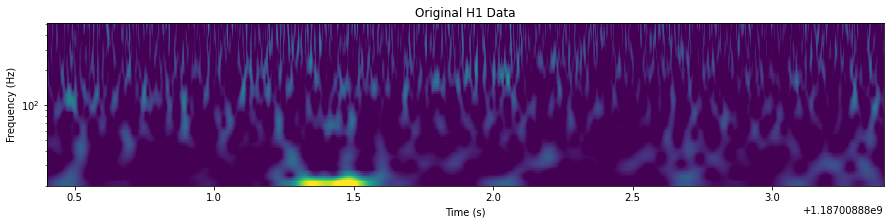

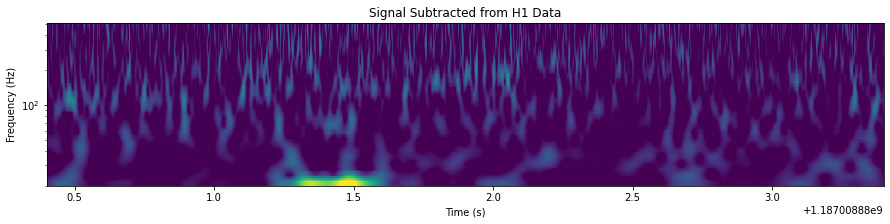

In [11]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

Now we will calculate the match between h* and h_t and plot it against the mass. 

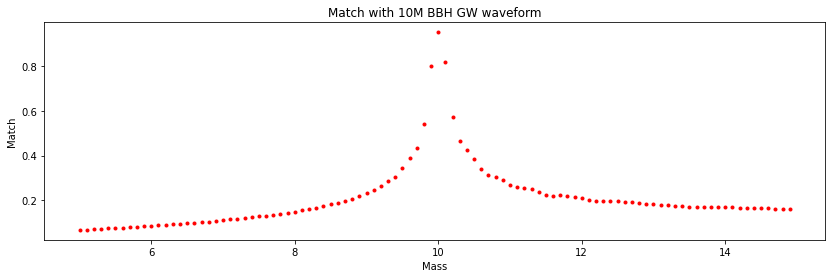

In [12]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096
masses = arange(5,15,0.1)
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[14, 4])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'r.')
pylab.show()

As expected the maximum of nearly a full match can be found around the mass of 10

# 2. Detector noise

For this task we first need to download the data and cast it into a TimeSeries

In [13]:
d = np.load('noise_ts_4096Hz.npy')

#After loading the data we must give it the shape of a TimeSeries 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d


After importing the data and transforming it into a TimeSeries format we can plot the PSD of the data 


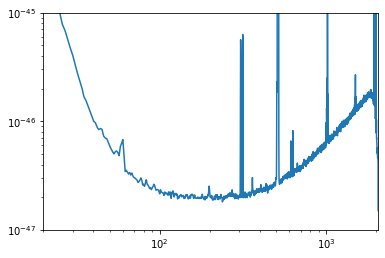

In [14]:
psds = interpolate(welch(d), 1.0 / d.duration)

pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, max(psds.sample_frequencies))
pylab.ylim(1e-47, 1e-45)
pylab.show()


In order to search for a Gravitational wave in the noise of the data a peak in the Signal to Noise Ratio(SNR) larger that 8 is required. In this example we assume two bodyies of equal mass and try to find a template waveform that satisfies the SNR condition.

In [20]:
flow = 30 #Hz
# cast to frequency series
stilde = data.to_frequencyseries()
#create list of masses
masses = arange(5,11,0.5)

# loop through the masses and create a waveform for each mass
for mass in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=mass, mass2=mass,
                             f_lower=flow, delta_f=stilde.delta_f)
  # resize
  hp.resize(len(stilde))  
  # calculate SNR
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)


  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]

  # Check if a GW (SNR>8 can be found)
  peak = abs(snr).numpy().argmax()
  snrp = snr[peak]
  if(snrp > 8):
    print('The equal masses of {} give an SNR greater that 8 in {}'.format(mass, abs(snrp)) )
  else:
    print('No SNR greater that 8 was detected. The maximal SNR at the mass of {} was {}'.format(mass, abs(snrp)))




No SNR greater that 8 was detected. The maximal SNR at the mass of 5.0 was 5.215891772105199
No SNR greater that 8 was detected. The maximal SNR at the mass of 5.5 was 5.163342296489468
No SNR greater that 8 was detected. The maximal SNR at the mass of 6.0 was 5.100873161342923
No SNR greater that 8 was detected. The maximal SNR at the mass of 6.5 was 5.6857317618465695
No SNR greater that 8 was detected. The maximal SNR at the mass of 7.0 was 5.092314227417557
No SNR greater that 8 was detected. The maximal SNR at the mass of 7.5 was 4.798273484351692
No SNR greater that 8 was detected. The maximal SNR at the mass of 8.0 was 5.9348137468235205
No SNR greater that 8 was detected. The maximal SNR at the mass of 8.5 was 5.565711108686226
No SNR greater that 8 was detected. The maximal SNR at the mass of 9.0 was 5.664784674730153
No SNR greater that 8 was detected. The maximal SNR at the mass of 9.5 was 5.877523831266216
No SNR greater that 8 was detected. The maximal SNR at the mass of 1

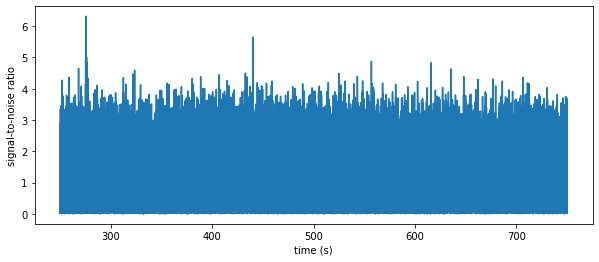

The most likely signal at 275.66552734375s with SNR 6.313764956876049


In [16]:
hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=9.25, mass2=9.25,
                             f_lower=flow, delta_f=stilde.delta_f)
hp.resize(len(stilde))  
snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)


  # Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print ( 'The most likely signal at {}s with SNR {}'.format(time, abs(snrp)) )

Since no ratio larger that 8 could be found, we can assume that this dataset does not contain any GW.

Whitening the data 

In [17]:
# Using the pycbc.psd library, whitening becomes rather trivial 

white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)

Plotting the whitened data shows the Gaussian nature of this distribution

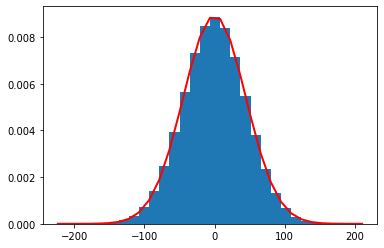

In [18]:
# Using the statistics library the can plot the histogram of the whitened data

mu, sigma, shape = mean(white_data), stdev(white_data), white_data.shape[0] # mean, standard deviation, shape
s = np.random.normal(mu, sigma, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.show()

## Non stationary Gaussian


In [21]:
from pycbc.waveform import get_fd_waveform
# firstly create a waveform that we will experiment on 
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0) #Luminosity distance = 500 Mpc


In [22]:
# Here we slice the data 
data_slice = int(len(data)/1000)
SNRlist = []

# loop throug all slices and estimate the psd for each slice
for i in range(0, 1000):

  data_chunk = data[i * data_slice: (i+1)*data_slice]

  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)

  SNR = (pycbc.filter.sigmasq(hp, psds))**0.5

  SNRlist.append(SNR)

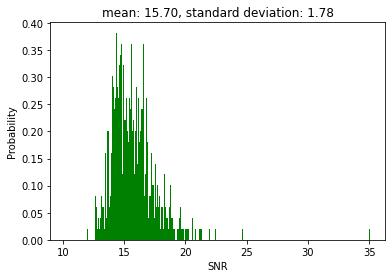

In [23]:
# Plotting histogram
plt.hist(SNRlist, bins = 500, color = "green", density=True)

# Plotting Best Fit
mu, sigma = mean(SNRlist), stdev(SNRlist)
y = norm.pdf(25, mu, sigma)
plt.plot(25, y)

plt.title('mean: {:.2f}, standard deviation: {:.2f}'.format(mu, sigma))
plt.xlabel("SNR")
plt.ylabel("Probability")


# show plot 
plt.show()

When inspecting the histogram a clear non Gaussian distribution is visible. 

# 3. Horizon distance of detectors

## LIGO detector

In the first step we we need to get the PSD if the LIGO detector.

interestingly the LIGO detector seems to have no spikes like the Einstein telescope and the other PSDs considered so far. 

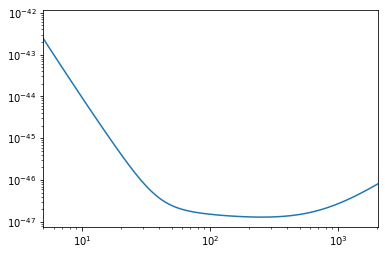

In [24]:
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# print(psd.sample_frequencies)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(5, max(psd.sample_frequencies))
# pylab.ylim(1e-49, 1e-47)
pylab.show()




In the second step we want to find the distance for which the the SNR reaches 8. In order to do so we initalize an abitrary distance of 1 Gpc to create the wave forms. The inverse proportionality of distance and SNR and the set SNR of 8, allow us to create the formula for distance: D = 1 Gpc * SNR/8.

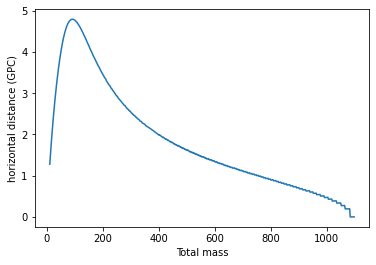

In [25]:
flow = 4.0 #Hz

masses = arange(5,550,1)
#setting the abitrary distance 
abDist = 1000

yplot = []
xplot = []

# Looping over the masses and creating the SNR for each mass
for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = abDist)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5
  
  # append the SNR/8 for 1 Gpc is the unit of the abitrary distance 
  yplot.append(SNR/8)
  # append m*2 for (m1 + m2) will be plotted 
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizontal distance (GPC)')
pylab.xlabel('Total mass')
pylab.show()

This graph shows up to which range the detector is able to detect GW of binary mass systems of different masses. The horizon distance is proportinal to the SNR at a constant distance. This means that at the distance 1Gpc the SNR is 8 times the horizontal distance/1Gpc. We see a clear peak at approximately 120 solar masses. 

My interpretation is that the frequency and the amplitude of the GW depends on the masses of the binary system. Until a certain mass we see the horizontal distance increase, for the amplitude of the more massive system increases while the frequency is still well inside the range of the detector. At some point however, the horizontal distance of the binary system decreases with increasing mass. This is the effect of the frequency of the GW increasing to a point where the detector starts to struggle with the frequency. Looking at the PCD plot we can see that the detectors struggle with higher frequency ranges. This effect requires higher amplitudes to compensate and thereby reduces the effective horizontal distance. 

This explantion also works when looking at the graphs for the EinsteinTelescope that peaks at a different mass. This indicates that this effect is detector reliant. 

## EinsteinTelescope

Again the PSD of the detector is considered

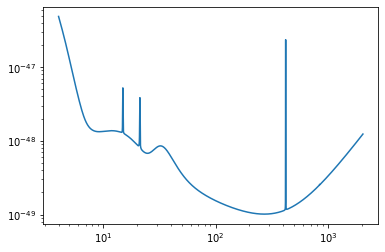

In [26]:
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# print(psd.sample_frequencies)

pylab.loglog(psd.sample_frequencies, psd)
pylab.show()

As in the analysis of the LIGO detector, the SNR will allow for finding the distance.

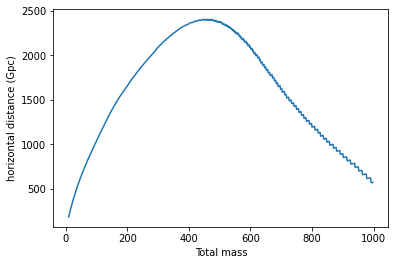

In [28]:
flow = 4.0 #Hz

masses = arange(5,500,1)

yplot = []
xplot = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5
  
  yplot.append(SNR/8)
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizontal distance (Gpc)')
pylab.xlabel('Total mass')
pylab.show()